In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ppls_sv import ProbabilisticPLS  # Import the updated PPLS class

# Data generation function with known stochastic volatility
def generate_synthetic_data(n, p, q, k, lambda_x, lambda_y, rng_seed=42):
    rng = np.random.default_rng(rng_seed)
    
    # Generate latent factors (n x k)
    F = rng.normal(size=(n, k))
    
    # Generate factor loadings (p x k for X, q x k for Y)
    P_true = rng.normal(size=(p, k))
    Q_true = rng.normal(size=(q, k))
    
    # Initialize volatilities with EWMA (n x 1)
    sigma2_x = np.zeros(n)
    sigma2_y = np.zeros(n)
    sigma2_x[0], sigma2_y[0] = 0.5, 0.5  # Initial volatilities

    # EWMA process to update volatilities
    for t in range(1, n):
        sigma2_x[t] = (1 - lambda_x) * rng.normal(scale=0.5) ** 2 + lambda_x * sigma2_x[t-1]
        sigma2_y[t] = (1 - lambda_y) * rng.normal(scale=0.5) ** 2 + lambda_y * sigma2_y[t-1]
    
    # Convert to standard deviations
    sigma_x = np.sqrt(sigma2_x)
    sigma_y = np.sqrt(sigma2_y)
    
    # Generate synthetic X and Y data with time-varying volatility
    X = F @ P_true.T + rng.normal(scale=sigma_x[:, None], size=(n, p))
    Y = F @ Q_true.T + rng.normal(scale=sigma_y[:, None], size=(n, q))

    return X, Y, P_true, Q_true, sigma_x, sigma_y

# Simulation parameters
n, p, q, k = 1000, 100, 50, 2
lambda_x, lambda_y = 0.99, 0.99  # EWMA smoothing parameters for X and Y
rng_seed = 42

# Generate synthetic data
X, Y, P_true, Q_true, true_sigma_x, true_sigma_y = generate_synthetic_data(n, p, q, k, lambda_x, lambda_y)


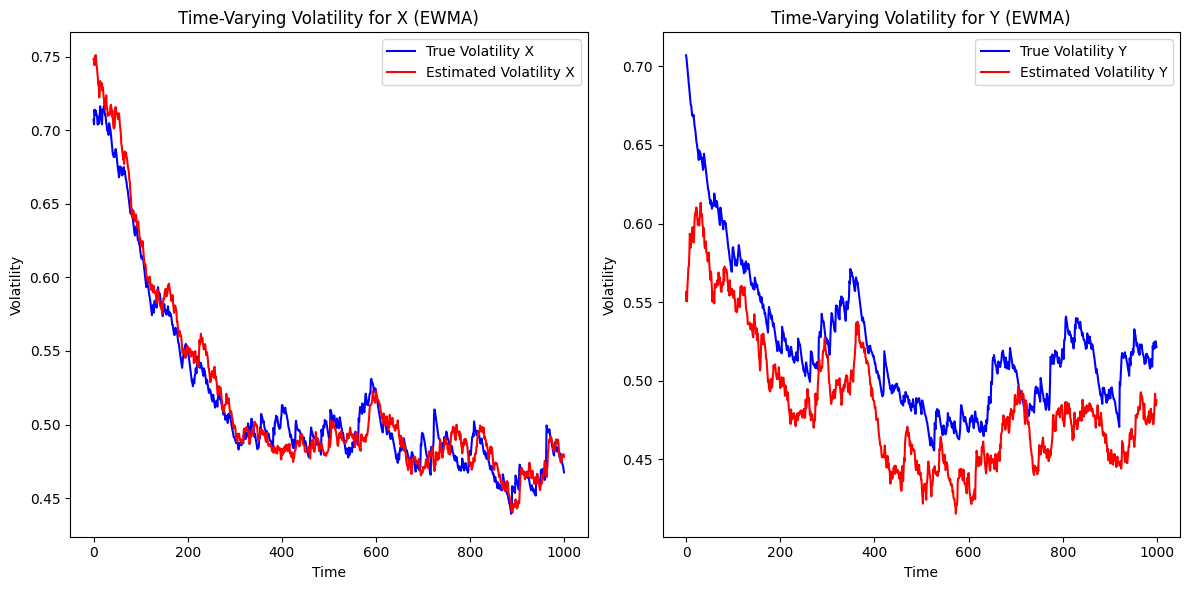

In [4]:
# Create and train the ProbabilisticPLS model with stochastic volatility
pls_model = ProbabilisticPLS(n_components=k)
pls_model.fit(X, Y, standardize=True)

# Fetch the estimated volatilities
estimated_sigma2_x = pls_model.sigma2_xx  # Estimated time-varying volatility for X (EWMA-based)
estimated_sigma2_y = pls_model.sigma2_yy  # Estimated time-varying volatility for Y (EWMA-based)

# Plot estimated vs true volatilities
plt.figure(figsize=(12, 6))

# Plot for X
plt.subplot(1, 2, 1)
plt.plot(true_sigma_x, label="True Volatility X", color="blue")
plt.plot(np.sqrt(estimated_sigma2_x), label="Estimated Volatility X", color="red")
plt.title("Time-Varying Volatility for X (EWMA)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()

# Plot for Y
plt.subplot(1, 2, 2)
plt.plot(true_sigma_y, label="True Volatility Y", color="blue")
plt.plot(np.sqrt(estimated_sigma2_y), label="Estimated Volatility Y", color="red")
plt.title("Time-Varying Volatility for Y (EWMA)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()

plt.tight_layout()
plt.show()
